In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
import pickle
with open('raw_data_20190115.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [50]:
ks11 = pd.read_csv('^ks11.csv')

In [51]:
ks11 = ks11.dropna()
del ks11['Volume']

In [52]:
ks11.index = ks11.Date.map(lambda x : pd.Timestamp(x))
del ks11['Date']

In [53]:
def add_feature(df):
    df["pct_change"] = df.Close.pct_change()
    for i in range(1, 91, 3):
        df["close_ma_{}".format(i)] = df.Close.rolling(window = i).mean()
#         df["volume_ma_{}".format(i)] = df.Volume.rolling(window = i).mean()
    for i in [7, 21, 30, 60, 90, 91, 100, 120]:
        df["his_vol_{}".format(i)] = df["pct_change"].rolling(window = i).std()*(252**0.5)
    for i in range(1, 91, 3):
        df['returnsCC{}'.format(i) ]= np.log(df.Open / df.Close.shift(i))
        df['returnsOO{}'.format(i) ] = np.log(df.Open / df.Open.shift(i))
        df['returnsCC{}'.format(i) ]= np.log(df.Close / df.Close.shift(i))
        df['returnsOC{}'.format(i) ] = np.log(df.Close / df.Open.shift(i))
    return df
def add_target(df):
    for i in range(1, 92, 3):
        for shift in range(1, 92, 3):
            df['sh{:03}_Y2_{:03}'.format(shift, i)] = df.Close.shift(-1*shift).rolling(i).mean() - df.Close.rolling(i).mean()
    return df

In [54]:
ks11 = add_feature(ks11)

In [55]:
ks11 = add_target(ks11)

In [56]:
ks11 = ks11.dropna()

In [65]:
X = [col for col in ks11.columns if col.find('Y2') == -1]
y_li = [col for col in ks11.columns if col.find('Y2') != -1]

In [63]:
train = ks11.loc['2013-01-01':'2018-01-01']
test = ks11.loc['2018-01-01':]

In [67]:
import xgboost as xgb

def modelfit(train, X, y):
    alg = XGBClassifier(
         learning_rate =0.15,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=2,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         nthread=4,
         scale_pos_weight=1,
         seed=27)
    xgb_params = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train[X].values, label=np.where(train[y].values>=0, 1,0))
    cvresult=xgb.cv(xgb_params, xgtrain,
                    num_boost_round=alg.get_params()['n_estimators'],
                    nfold=5, early_stopping_rounds=50,
                    show_stdv=False)
    alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(train[X].values, np.where(train[y].values>=0, 1,0), eval_metric='auc')
    return alg

In [68]:
from tqdm import tqdm_notebook

res = {}
for y in tqdm_notebook(y_li):
    model = modelfit(train, X, y)
    res[y] = model

In [73]:
y_li[0][2:5]

'001'

In [77]:
from sklearn import metrics
p = pd.DataFrame(index = [i for i in range(1,91,3)], columns=[i for i in range(1,91,3)])
for y, alg in res.items():
    shift = int(y[2:5])
    ma = int(y[-3:])
    acc = metrics.accuracy_score(np.where(test[y].values>=0, 1,0), alg.predict(test[X].values))
    p.loc[ma, shift] = acc

In [85]:
p

,1,4,7,10,13,16,19,22,25,28,...,64,67,70,73,76,79,82,85,88,91
1,0.551515,0.539394,0.521212,0.49697,0.575758,0.593939,0.527273,0.515152,0.484848,0.563636,...,0.242424,0.242424,0.30303,0.284848,0.212121,0.30303,0.278788,0.660606,0.436364,0.393939
4,0.739394,0.593939,0.539394,0.50303,0.545455,0.593939,0.557576,0.563636,0.575758,0.563636,...,0.254545,0.369697,0.315152,0.29697,0.375758,0.260606,0.309091,0.278788,0.309091,0.636364
7,0.818182,0.666667,0.521212,0.557576,0.515152,0.551515,0.642424,0.587879,0.478788,0.648485,...,0.254545,0.321212,0.393939,0.484848,0.363636,0.30303,0.266667,0.290909,0.272727,0.248485
10,0.824242,0.763636,0.666667,0.545455,0.624242,0.557576,0.654545,0.624242,0.660606,0.745455,...,0.260606,0.212121,0.412121,0.393939,0.393939,0.363636,0.284848,0.248485,0.272727,0.230303
13,0.860606,0.751515,0.739394,0.624242,0.533333,0.557576,0.593939,0.630303,0.824242,0.787879,...,0.266667,0.236364,0.224242,0.266667,0.418182,0.30303,0.29697,0.272727,0.248485,0.248485
16,0.854545,0.836364,0.751515,0.654545,0.660606,0.624242,0.563636,0.642424,0.763636,0.8,...,0.169697,0.230303,0.224242,0.212121,0.181818,0.363636,0.309091,0.290909,0.278788,0.284848
19,0.842424,0.824242,0.806061,0.69697,0.642424,0.709091,0.612121,0.733333,0.745455,0.721212,...,0.2,0.212121,0.2,0.193939,0.284848,0.248485,0.339394,0.224242,0.357576,0.363636
22,0.836364,0.854545,0.793939,0.751515,0.733333,0.660606,0.678788,0.630303,0.527273,0.690909,...,0.115152,0.175758,0.157576,0.115152,0.193939,0.230303,0.315152,0.363636,0.490909,0.575758
25,0.866667,0.854545,0.830303,0.751515,0.751515,0.672727,0.690909,0.69697,0.69697,0.606061,...,0.2,0.145455,0.109091,0.187879,0.181818,0.2,0.333333,0.333333,0.363636,0.472727
28,0.921212,0.848485,0.793939,0.8,0.690909,0.618182,0.630303,0.690909,0.648485,0.636364,...,0.121212,0.139394,0.127273,0.2,0.193939,0.181818,0.181818,0.181818,0.418182,0.393939


In [86]:
with open('original_20190119.pickle', 'wb') as handle:
    pickle.dump((p, res), handle, pickle.HIGHEST_PROTOCOL)

In [87]:
ks11 = pd.read_csv('^ks11.csv')
ks11 = ks11.dropna()
del ks11['Volume']
ks11.index = ks11.Date.map(lambda x : pd.Timestamp(x))
del ks11['Date']

In [88]:
def get_MACD(df, short_ma=12, long_ma=26, signal_period=9):
    ewm_12 = df['Close'].ewm(span = short_ma, min_periods = short_ma - 1).mean()
    ewm_26 = df['Close'].ewm(span = long_ma, min_periods = long_ma - 1).mean()
    df['MACD'] = ewm_12 - ewm_26
    df['MACDSignal'] = df['MACD'].ewm(span = signal_period, min_periods = signal_period-1).mean()
    df['MACDDiff'] = df['MACD'] - df['MACDSignal']
    return df

def get_Stochastic(df, n=14):
    df['sto_K_{}'.format(n)] = 100 * ((df.Close - df.Low.rolling(n).min()) / 
                                      (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['sto_D_{}'.format(n)] = df['sto_K_{}'.format(n)].rolling(3).mean()
    return df
    
def get_RSI(df, n=14):
    U = np.where(df['Close'].diff(1)>0, df['Close'].diff(1), 0)
    D = np.where(df['Close'].diff(1)<0, df['Close'].diff(1)*(-1), 0)
    
    AU = pd.Series(U).rolling(window=n, min_periods=n).mean()
    AD = pd.Series(D).rolling(window=n, min_periods=n).mean()
    
    RSI = AU.div(AD+AU) * 100
    df['RSI_{}'.format(n)] = RSI.values
    return df
    
def get_BolingerBand(df, n=20, k=2):
    df = df.assign(BolingerCenter = df['Close'].rolling(window=n).mean())
    df = df.assign(Bol_upper = df['Close'].rolling(window=n).mean() + k*df['Close'].rolling(window=n).std())
    df = df.assign(Bol_lower = df['Close'].rolling(window=n).mean() - k*df['Close'].rolling(window=n).std())
    return df

def get_SMA(df, window):
    df['close_ma_{}'.format(window)] = df['Close'].rolling(window).mean()
    return df
    
def get_EMA(df, window):
    df['close_ema_{}'.format(window)] = df['Close'].ewm(span=window).mean()
    return df
    
def get_RoC(df, periods):
    df['roc_{}'.format(periods)] = df['Close'].pct_change(periods=periods)
    return df
    
def get_CV(df, window):
    df['his_vol_{}'.format(window)] = np.log(df['Close'] / df['Close'].shift(1)).rolling(window).std()*(252**0.5)
    return df
    
def get_WilliamR(df, n):
    W_R = -100 * ((df.High.rolling(n).max() - df.Close) / (df.High.rolling(n).max() - df.Low.rolling(n).min()))
    df['WR_{}'.format(n)] = W_R
    return df
    
def get_CCI(df, window):
    TP = (df.Close + df.Low + df.High) / 3
    dataX = []
    for i in range(len(TP) - window+1):
        a = TP.values[i:(i+window)]
        dataX.append(a)
    dataMean = [i.mean() for i in dataX]
    AVEDEV = [abs(x - mean).mean() for x, mean 
              in zip(dataX, dataMean)]
    for i in range(window-1):
        AVEDEV.insert(0,np.nan)
    AVEDEV = pd.Series(AVEDEV, index = TP.index)
    CCI = (TP - TP.rolling(20).mean()) / (0.015 * AVEDEV)
    df['CCI_{}'.format(window)] = CCI
    return df
    
def get_DI(df, window):
    df['DI_{}'.format(window)] = 100 * ((df.Close - df.Close.rolling(window).mean()) / df.Close.rolling(window).mean())
    return df

def get_VPT(df):
    df['VPT'] = ((test.Close.diff(1) / test.Close) * test.Volume).cumsum()
    return df
    
def get_MA_diff(df, window):
    df['ma_diff_{}'.format(window)] = df['Close'].rolling(window).mean() - df['Close'].shift(window).rolling(window).mean()
    return df

def get_MA_n_diff(df, n, window):
    df['ma_{}_diff_{}'.format(n, window)] = df['Close'].rolling(window).mean() - df['Close'].rolling(window+n).mean()
    return df
    
def get_OBV(df):
    df['OBV'] = (np.sign(df['Close'].diff(1).fillna(0)) * df['Volume']).cumsum()
    return df

In [90]:
for window in range(1, 91):
    ks11 = get_SMA(ks11, window)
    ks11 = get_EMA(ks11, window)
n = 10
for window in range(1, 91):
    ks11 = get_MA_diff(ks11, window)
    ks11 = get_MA_n_diff(ks11, n, window)
for window in range(12, 91):
    ks11 = get_CV(ks11, window)
for periods in range(1, 11):
    ks11 = get_RoC(ks11, periods)
for n in range(3, 91):
    ks11 = get_RSI(ks11, n)
    ks11 = get_Stochastic(ks11, n)
    ks11 = get_WilliamR(ks11, n)
ks11 = get_CCI(ks11, 20)
for window in [5,10]:
    ks11 = get_DI(ks11, window)
ks11 = get_MACD(ks11)
# ks11 = get_OBV(ks11)

In [91]:
ks11 = add_target(ks11)

In [97]:
ks11

,Open,High,Low,Close,Adj Close,close_ma_1,close_ema_1,close_ma_2,close_ema_2,close_ma_3,...,sh064_Y2_091,sh067_Y2_091,sh070_Y2_091,sh073_Y2_091,sh076_Y2_091,sh079_Y2_091,sh082_Y2_091,sh085_Y2_091,sh088_Y2_091,sh091_Y2_091
Date,,,,,,,,,,,,,,,,,,,,,
1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,758.030029,758.030029,NaN,758.030029,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,777.289978,777.289978,767.660004,772.474991,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-03,778.820007,782.169983,773.270020,775.260010,775.260010,775.260010,775.260010,776.274994,774.403081,770.193339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-04,776.020020,783.239990,773.900024,781.700012,781.700012,781.700012,781.700012,778.480011,779.328509,778.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-07,777.700012,777.750000,772.140015,773.510010,773.510010,773.510010,773.510010,777.605011,775.433481,776.823344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-08,773.000000,774.000000,761.570007,767.739990,767.739990,767.739990,767.739990,770.625000,770.297442,774.316671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-09,768.260010,772.239990,763.969971,771.989990,771.989990,771.989990,771.989990,769.864990,771.426323,771.079997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-10,771.989990,773.169983,765.500000,767.770020,767.770020,767.770020,767.770020,769.880005,768.988416,769.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-07-11,766.909973,771.080017,762.710022,768.299988,768.299988,768.299988,768.299988,768.035004,768.529441,769.353333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
ks11 = ks11.dropna().loc['2010-10-01':'2018-08-01']

In [101]:
corr_

sh001_Y2_001    1.0
Name: sh001_Y2_001, dtype: float64

In [103]:
col_name

'OBV'

In [104]:
y_li = [col for col in ks11 if col.find('Y') != -1]

target_set = {}
for y in tqdm_notebook(y_li):
    col_set = {}
    for col_name in ['sto_K','sto_D','RSI','close_ma','close_ema','roc','his_vol','WR',
                     'CCI','DI','ma_diff','MACD','MACDSignal','MACDDiff']:
        corr_ = abs(ks11[[col for col in ks11 if (col.find(col_name) != -1)|
                (col.find(y) != -1)]].corr()[y]).sort_values(ascending=False)
        col_set[corr_.index[1]] = corr_.iloc[1]
    target_set[y] = col_set

In [106]:
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [107]:
dataset = {}
for y, X in target_set.items():
    dataset[y] = (ks11[list(X.keys())], ks11[y])

In [114]:
train_set = {}
test_set = {}
for y, data in dataset.items():
    std = StandardScaler()
    std.fit(data[0].loc['2013-01-01':'2018-01-01'].values)
    train_set[y] = (std.transform(data[0].loc['2013-01-01':'2018-01-01'].values), 
                    data[1].loc['2013-01-01':'2018-01-01'])
    test_set[y] = (std.transform(data[0].loc['2018-01-01':].values), 
                   data[1].loc['2018-01-01':])

In [119]:
def modelfit2(train_set):
    alg = XGBClassifier(
         learning_rate =0.15,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=2,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         nthread=4,
         scale_pos_weight=1,
         seed=27)
    xgb_params = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(train_set[0], label=np.where(train_set[1]>=0, 1,0))
    cvresult=xgb.cv(xgb_params, xgtrain,
                    num_boost_round=alg.get_params()['n_estimators'],
                    nfold=5, early_stopping_rounds=50,
                    show_stdv=False)
    alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(train_set[0], np.where(train_set[1]>=0, 1,0), eval_metric='auc')
    return alg

In [120]:
res2 = {}
for y in tqdm_notebook(y_li):
    model = modelfit2(train_set[y])
    res2[y] = model

q = pd.DataFrame(index = [i for i in range(1,91,3)], columns=[i for i in range(1,91,3)])
for y, alg in res2.items():
    shift = int(y[2:5])
    ma = int(y[-3:])
    acc = metrics.accuracy_score(np.where(test_set[y][1]>=0, 1,0), alg.predict(test_set[y][0]))
    q.loc[ma, shift] = acc

In [126]:
p.columns = ['p_'+str(i) for i in p.columns]
q.columns = ['q_'+str(i) for i in q.columns]

In [1]:
5

5

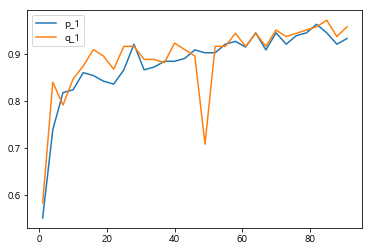

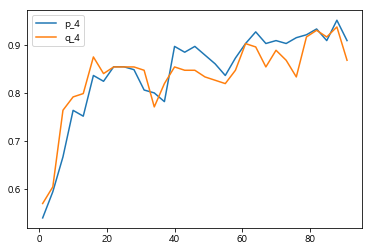

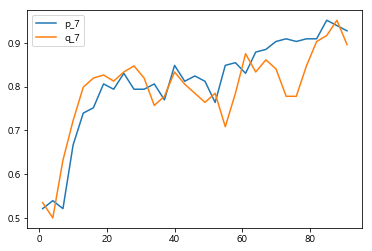

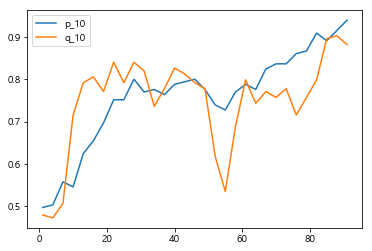

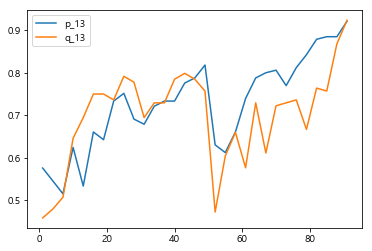

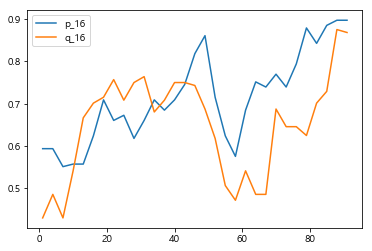

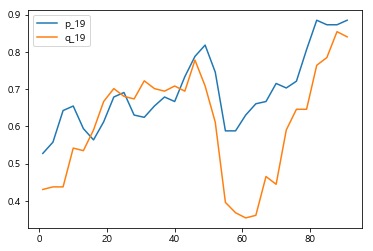

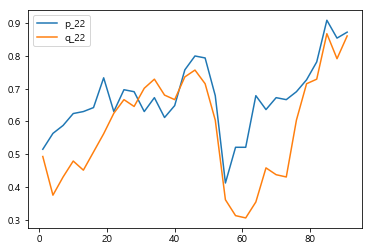

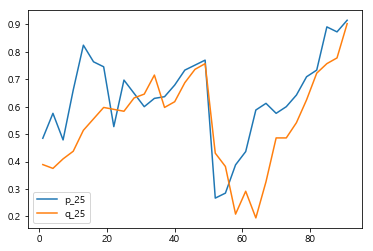

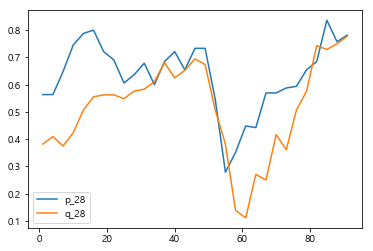

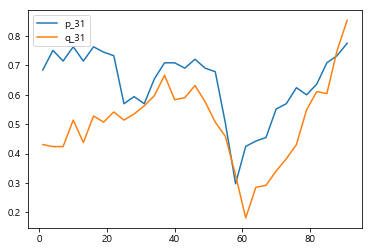

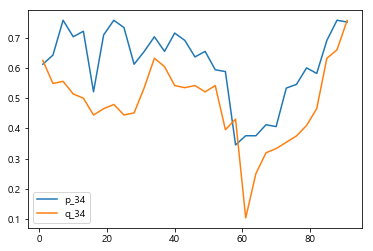

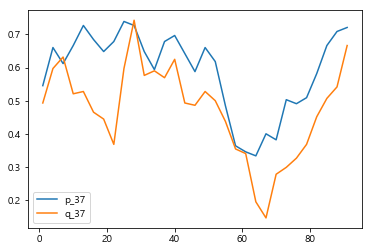

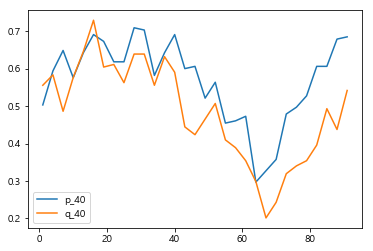

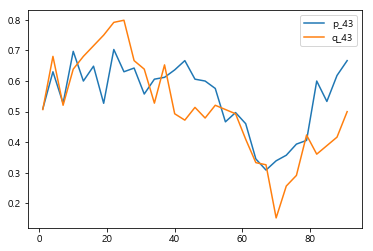

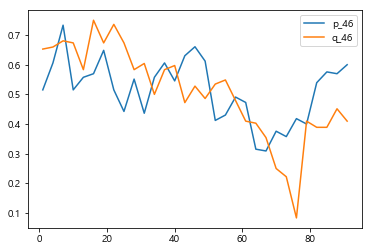

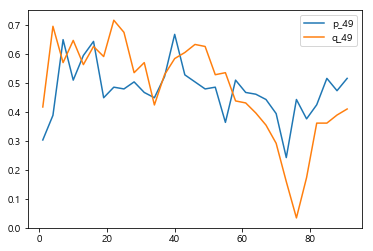

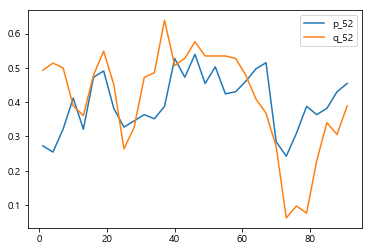

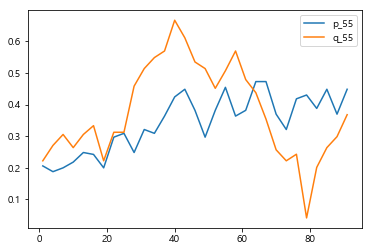

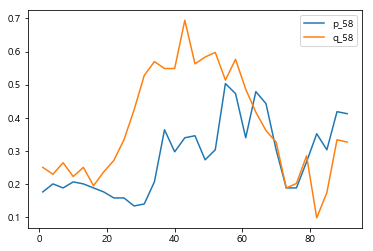

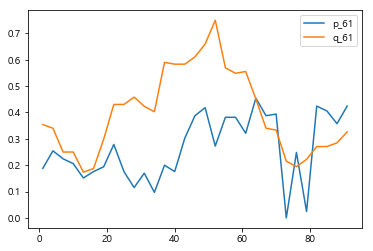

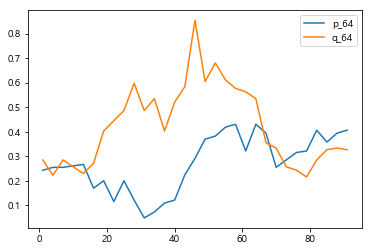

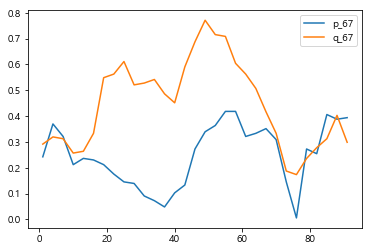

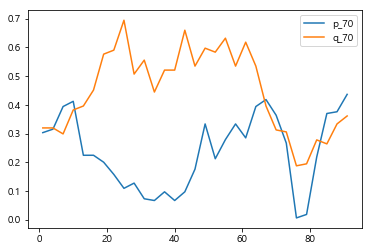

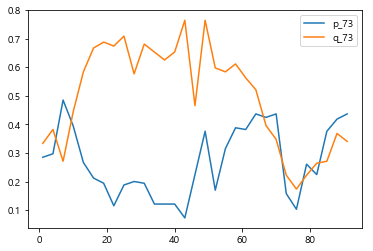

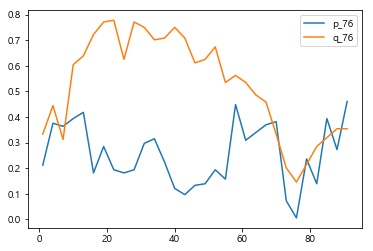

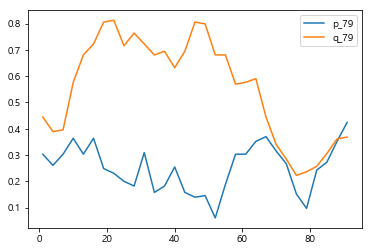

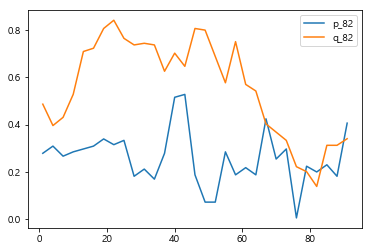

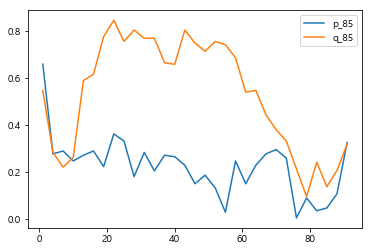

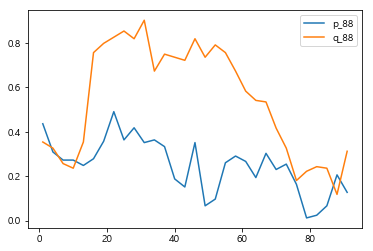

In [129]:
for n_pred in range(1,91, 3):
    pd.concat((p['p_{}'.format(n_pred)], q['q_{}'.format(n_pred)]),axis=1).plot()
    plt.show()